<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Project 1: Comparing ACT and SAT Scores for US College Admission

## 1. Problem Statement

This project is meant to help high school students decide between taking ACT or SAT for their college admission.

SAT and ACT are standardized tests that many colleges and universities in the United States require for their admission process. Since the advent of ACT, the SAT and ACT have been in [rivalry](https://www.bestcolleges.com/blog/history-of-act/). Despite their [differences](https://www.crimsoneducation.org/sg/blog/test-prep/sat-vs-act-whats-the-difference/), there have been online resources to convert SAT and ACT interchangably. For example, see [the princeton review](https://www.princetonreview.com/college-advice/act-to-sat-conversion), [crimson education](https://www.crimsoneducation.org/sg/blog/test-prep/sat-vs-act-whats-the-difference/) etc.

This project shall aim to:
1. examine the reliability of the SAT and ACT concordance table taken from the respective official board website by comparing it with the college admission scores and stats admission scores; 
2. advise students on which test to take in order to better their chance to enroll in their dream colleges;
3. advise students on which test to fare better given the state they reside in; and
4. provide further analysis using logistic regression on the findings from point 2 and point 3.

## 2. Background

## 3. Datasets

The project will make use of the following datasets for analysis:
1. [`act_2019.csv`](./data/act_2019.csv): 2019 ACT Scores by State ([*source*](https://blog.prepscholar.com/act-scores-by-state-averages-highs-and-lows))
2. [`sat_2019.csv`](./data/sat_2019.csv): 2019 SAT Scores by State ([*source*](https://blog.prepscholar.com/average-sat-scores-by-state-most-recent))
3. [`sat_act_by_college.csv`](./data/sat_act_by_college.csv): Ranges of Accepted ACT & SAT Student Scores by Colleges ([*source*](https://www.compassprep.com/college-profiles/))
4. [`sat_act_score_convertor.csv`](./data/sat_act_score_convertor.csv): ACT & SAT Student Scores Concordance Table from offical websites (sources: [ACT](https://www.act.org/content/act/en/products-and-services/the-act/scores/act-sat-concordance.html) & [SAT](https://satsuite.collegeboard.org/higher-ed-professionals/score-reports/score-comparisons/sat-act))

## 4. Library Imports and Functions Creation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from warnings import simplefilter

In [2]:
# function for normality + statistical significance check
def cont_stat_sig_test(df,col):
    # Step 1: normality test
    stat, p_value = stats.normaltest(df[col].values)
    
    # Step 2: filter series    
    neutral = df[df['recommendation']=='Neutral'][col].values
    sat_preferred = df[df['recommendation']=='SAT Preferred'][col].values
    act_preferred = df[df['recommendation']=='ACT Preferred'][col].values
    
    # Step 3: determining appropriate statistical significance test based on normality
    if p_value>0.01:
        distribution = 'normal distribution'
        test = 'Anova test'
        stat, p_value = stats.f_oneway(neutral, sat_preferred, act_preferred)
    
    else:
        distribution = 'non-normal distribution'
        test = 'KW test'
        stat, p_value = stats.kruskal(neutral, sat_preferred, act_preferred)
    
    # Step 4: conclude on statistical significance
    if p_value>0.05:
        sig = 'not statistically significant'
    else:
        sig = 'statistically significant'

    print(f'{col}: {distribution}, {test}, {sig}, {p_value}')

In [3]:
# function for heatmap
def heatmap(df):
    simplefilter(action='ignore', category=DeprecationWarning)
    plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    mask = mask[1:, :-1]
    corr1 = df.corr().iloc[1:,:-1].copy()
    corr2 = sns.heatmap(corr1,mask=mask, cmap='coolwarm_r', annot=True, fmt=".2f", annot_kws={'fontsize':16},linewidths=4, cbar = False,)
    corr2.set_yticklabels(corr2.get_ymajorticklabels(), fontsize = 10)
    corr2.set_xticklabels(corr2.get_xmajorticklabels(), fontsize = 10);

In [4]:
# defining a function for horizontal bar graph
def bar(df):
    warnings.filterwarnings("ignore")
    plt.subplots(figsize=(10, 8))
    recommendation_bar = sns.barplot(data=df,y=df['recommendation'].value_counts().index,x=df['recommendation'].value_counts().values)
    recommendation_bar.set_xticklabels(recommendation_bar.get_xticks(), size=14)
    recommendation_bar.set_yticklabels(df['recommendation'].value_counts().index, size=14)
    recommendation_bar.bar_label(recommendation_bar.containers[0], size=14);

## 4. Data Cleaning

In [5]:
act_2019 = pd.read_csv('../data/act_2019.csv')
sat_2019 = pd.read_csv('../data/sat_2019.csv')
sat_act_by_college = pd.read_csv('../data/sat_act_by_college.csv')
sat_act_score_convertor = pd.read_csv('../data/sat_act_score_convertor.csv')

### 4.1 Individual Dataset

We shall proceed to:
1. examine each of the datasets; and 
2. prepare each data for further analysis based on the observations made.

#### 'act_2019' Dataset

In [6]:
act_2019.head()

,State,Participation,Composite
0,Alabama,100%,18.9
1,Alaska,38%,20.1
2,Arizona,73%,19.0
3,Arkansas,100%,19.3
4,California,23%,22.6


In [7]:
act_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State          52 non-null     object 
 1   Participation  52 non-null     object 
 2   Composite      52 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.3+ KB


In [8]:
# clarifying the unique stats in order to compare with sat_2019 dataset
print(act_2019['State'].unique())
print('\n')
print(f'The number of unique states is {act_2019.State.nunique()}.')

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'National']


The number of unique states is 52.


### <span style="color: Blue;">Observation</span>

The dataset has no missing and suspicious value.

There are three things that we want to adjust for the 'act_2019.csv' Dataset :-
1. Drop the % under the participation rate column and change its value to integer.
2. Round composite score to integer as ACT score is [only meaningful](https://www.quadeducationgroup.com/blog/act-scores-everything-you-need-to-know) as a whole number.
3. Rename the columns to standardise with the 'sat_2019.csv' Dataset.

In [9]:
act_2019['Participation'] = act_2019['Participation'].str.replace('%','').astype(int)
act_2019.head()

,State,Participation,Composite
0,Alabama,100,18.9
1,Alaska,38,20.1
2,Arizona,73,19.0
3,Arkansas,100,19.3
4,California,23,22.6


In [10]:
# showing that the rounding of values does not have much impact on the values given the high correlation
act_2019['Composite'].corr(act_2019['Composite'].round(0).astype(int))

0.9911093015066212

In [11]:
act_2019['Composite'] = act_2019['Composite'].round(0).astype(int)
act_2019.head()

,State,Participation,Composite
0,Alabama,100,19
1,Alaska,38,20
2,Arizona,73,19
3,Arkansas,100,19
4,California,23,23


In [12]:
act_2019.rename(columns={'State': 'state',
                         'Participation': 'act_participation_%',
                         'Composite': 'act_composite'}, inplace=True)
act_2019.head()

,state,act_participation_%,act_composite
0,Alabama,100,19
1,Alaska,38,20
2,Arizona,73,19
3,Arkansas,100,19
4,California,23,23


#### 'sat_2019' Dataset

In [13]:
sat_2019.head()

,State,Participation Rate,EBRW,Math,Total
0,Alabama,7%,583,560,1143
1,Alaska,41%,556,541,1097
2,Arizona,31%,569,565,1134
3,Arkansas,6%,582,559,1141
4,California,63%,534,531,1065


In [14]:
sat_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   State               53 non-null     object
 1   Participation Rate  53 non-null     object
 2   EBRW                53 non-null     int64 
 3   Math                53 non-null     int64 
 4   Total               53 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.2+ KB


In [15]:
# need this to compare with act_2019 dataset
print(sat_2019['State'].unique())
print('\n')
print(f'The number of unique states is {sat_2019.State.nunique()}.')
# notice that the dataset has two more stats as compared to the act_2019 dataset (namely, Puerto Rico and Virgin Islands)
# notice also that the act_2019 dataset has a national average

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virgin Islands' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin'
 'Wyoming']


The number of unique states is 53.


### <span style="color: Blue;">Observation</span>

The dataset has no missing and suspicious value.

There are four things that we want to adjust for the 'sat_2019.csv' Dataset :-

1. Delete the rows of consisting Puerto Rico and Virgin Islands of sat_2019 dataset. Although they are under US's territory, they are not considered [US states](https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations).
2. Drop the % under the participation rate column and change its value to integer.
3. Compute national average in sat_2019 dataset based on the remaining states. As we do not have any information on how national average was caculated in the act_2019 dataset, this is the next best alternative method.
4. Rename the columns to standardise with the 'sat_2019.csv' Dataset.

In [16]:
sat_2019 = sat_2019[(sat_2019.State  != 'Puerto Rico') & (sat_2019.State  != 'Virgin Islands')]
print(sat_2019['State'].unique())
print('\n')
print(f'The number of unique states is {sat_2019.State.nunique()}.')

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


The number of unique states is 51.


In [17]:
sat_2019['Participation Rate'] = sat_2019['Participation Rate'].str.replace('%','').astype(int)
sat_2019.head()

,State,Participation Rate,EBRW,Math,Total
0,Alabama,7,583,560,1143
1,Alaska,41,556,541,1097
2,Arizona,31,569,565,1134
3,Arkansas,6,582,559,1141
4,California,63,534,531,1065


In [18]:
simplefilter(action='ignore', category=FutureWarning)
nat_avg = {'State':'National',
           'Participation Rate':sat_2019['Participation Rate'].mean().astype(int),
           'EBRW':sat_2019['EBRW'].mean().astype(int),
           'Math':sat_2019['Math'].mean().astype(int),
           'Total':sat_2019['Total'].mean().astype(int)}
sat_2019 = sat_2019.append(nat_avg, ignore_index = True)
sat_2019.tail()

,State,Participation Rate,EBRW,Math,Total
47,Washington,70,539,535,1074
48,West Virginia,99,483,460,943
49,Wisconsin,3,635,648,1283
50,Wyoming,3,623,615,1238
51,National,49,560,552,1113


In [19]:
sat_2019.rename(columns={'State': 'state',
                         'Participation Rate': 'sat_participation_%',
                         'EBRW': 'sat_ebrw',
                         'Math': 'sat_math',
                         'Total':'sat_total'}, inplace=True)
sat_2019.head()

,state,sat_participation_%,sat_ebrw,sat_math,sat_total
0,Alabama,7,583,560,1143
1,Alaska,41,556,541,1097
2,Arizona,31,569,565,1134
3,Arkansas,6,582,559,1141
4,California,63,534,531,1065


#### 'sat_act_by_college' Dataset

In [20]:
sat_act_by_college.head()

,School,Test Optional?,Applies to Class Year(s),Policy Details,Number of Applicants,Accept Rate,SAT Total 25th-75th Percentile,ACT Total 25th-75th Percentile
0,Stanford University,Yes,2021,Stanford has adopted a one-year test optional ...,47452,4.3%,1440-1570,32-35
1,Harvard College,Yes,2021,Harvard has adopted a one-year test optional p...,42749,4.7%,1460-1580,33-35
2,Princeton University,Yes,2021,Princeton has adopted a one-year test optional...,35370,5.5%,1440-1570,32-35
3,Columbia University,Yes,2021,Columbia has adopted a one-year test optional ...,40203,5.5%,1450-1560,33-35
4,Yale University,Yes,2021,Yale has adopted a one-year test optional poli...,36844,6.1%,1460-1570,33-35


In [21]:
sat_act_by_college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   School                          416 non-null    object
 1   Test Optional?                  416 non-null    object
 2   Applies to Class Year(s)        390 non-null    object
 3   Policy Details                  416 non-null    object
 4   Number of Applicants            416 non-null    int64 
 5   Accept Rate                     416 non-null    object
 6   SAT Total 25th-75th Percentile  416 non-null    object
 7   ACT Total 25th-75th Percentile  416 non-null    object
dtypes: int64(1), object(7)
memory usage: 26.1+ KB


### <span style="color: Blue;">Observation</span>

There are null values in the dataset but the column is not required for analysis.

There are four things that we want to adjust for the 'sat_act_by_college.csv' Dataset :-

1. Drop the rows of colleges without both ACT and SAT scores as they are not useful for analysis with the ACT and SAT scores of the concordance table.
2. Pick out the score of 25th percentile of the ACT and SAT score columns. Given that the analysis is meant to gauge the admission scores of both tests required to enter the colleges, the score at 25th percentile would be more useful. The lower the percentile the better we can gauge the minimum scores required to enter each college. 
3. Convert the values of the 25th percentile of the ACT and SAT score columns to integers for analysis.
4. Rename the columns to represent the values.

In [22]:
# working on the sat_act_by_college['SAT Total 25th-75th Percentile'] column 
sat_act_by_college['SAT Total 25th-75th Percentile'].unique()

array(['1440-1570', '1460-1580', '1450-1560', '1460-1570',
       '\u200b\u200b 1530-1560', '\u200b\u200b 1500-1570',
       '\u200b\u200b 1440-1570', '\u200b\u200b 1490-1570', '1390-1540',
       '1440-1560', '1330-1520', '1450-1570', '1380-1540', '1440-1550',
       '1460-1560', '1360-1510', '1470-1560', '1400-1560', '1410-1550',
       '1340-1520', '1270-1480', '1290-1510', '1360-1520', '1350-1530',
       '1350-1510', '1340-1490', '1300-1480', '1490-1570', '1370-1530',
       '1300-1530', '1470-1570', '1360-1530', '1400-1550', '1283-1510',
       '1370-1510', '1320-1510', '1370-1520', '1310-1485', '1350-1520',
       '1360-1540', '1300-1510', '1348-1490', '1330-1500', '1300-1490',
       '1340-1530', '1180-1440', '1340-1500', '1270-1450', '1280-1420',
       '1370-1490', '1320-1470', '1290-1460', '1250-1420', '1290-1450',
       '1300-1500', '1260-1460', '1320-1490', '1220-1400', '1250-1470',
       '1250-1460', '1280-1500', '1250-1440', '1220-1380', '1240-1470',
       '1333-1490'

In [23]:
sat_act_by_college['SAT Total 25th-75th Percentile'] = sat_act_by_college['SAT Total 25th-75th Percentile'].str.replace('\u200b','')
sat_act_by_college['SAT Total 25th-75th Percentile'] = sat_act_by_college['SAT Total 25th-75th Percentile'].str.strip()
sat_act_by_college = sat_act_by_college[(sat_act_by_college["SAT Total 25th-75th Percentile"]  != '--')]
sat_act_by_college['SAT Total 25th-75th Percentile'].unique()

array(['1440-1570', '1460-1580', '1450-1560', '1460-1570', '1530-1560',
       '1500-1570', '1490-1570', '1390-1540', '1440-1560', '1330-1520',
       '1450-1570', '1380-1540', '1440-1550', '1460-1560', '1360-1510',
       '1470-1560', '1400-1560', '1410-1550', '1340-1520', '1270-1480',
       '1290-1510', '1360-1520', '1350-1530', '1350-1510', '1340-1490',
       '1300-1480', '1370-1530', '1300-1530', '1470-1570', '1360-1530',
       '1400-1550', '1283-1510', '1370-1510', '1320-1510', '1370-1520',
       '1310-1485', '1350-1520', '1360-1540', '1300-1510', '1348-1490',
       '1330-1500', '1300-1490', '1340-1530', '1180-1440', '1340-1500',
       '1270-1450', '1280-1420', '1370-1490', '1320-1470', '1290-1460',
       '1250-1420', '1290-1450', '1300-1500', '1260-1460', '1320-1490',
       '1220-1400', '1250-1470', '1250-1460', '1280-1500', '1250-1440',
       '1220-1380', '1240-1470', '1333-1490', '1280-1450', '1300-1460',
       '1210-1380', '1110-1320', '1270-1460', '1260-1430', '1255

In [24]:
sat_act_by_college['SAT Total 25th-75th Percentile'] = sat_act_by_college['SAT Total 25th-75th Percentile'].map(lambda x: str(x)[:-5])

In [25]:
sat_act_by_college['SAT Total 25th-75th Percentile'].unique()

array(['1440', '1460', '1450', '1530', '1500', '1490', '1390', '1330',
       '1380', '1360', '1470', '1400', '1410', '1340', '1270', '1290',
       '1350', '1300', '1370', '1283', '1320', '1310', '1348', '1180',
       '1280', '1250', '1260', '1220', '1240', '1333', '1210', '1110',
       '1255', '1200', '1040', '1090', '1030', '1100', '890', '1325',
       '1150', '1160', '1130', '1080', '1230', '1190', '1140', '1020',
       '990', '1050', '1203', '950', '1070', '1170', '910', '1060',
       '1120', '1142.5', '1045', '1248', '1010', '1078', '940', '1000',
       '980', '1153', '1012', '1108', '970', '1038', '960', '1143',
       '1008', '1245', '1275', '793', '820'], dtype=object)

In [26]:
for i in sat_act_by_college['SAT Total 25th-75th Percentile']:
    if len(i) > 4:
        print(i)

1142.5


In [27]:
sat_act_by_college['SAT Total 25th-75th Percentile'] = sat_act_by_college['SAT Total 25th-75th Percentile'].astype(float)
sat_act_by_college['SAT Total 25th-75th Percentile'] = sat_act_by_college['SAT Total 25th-75th Percentile'].round()
sat_act_by_college['SAT Total 25th-75th Percentile'] = sat_act_by_college['SAT Total 25th-75th Percentile'].astype(int)

In [28]:
# working on the sat_act_by_college['ACT Total 25th-75th Percentile'] column 
sat_act_by_college['ACT Total 25th-75th Percentile'].unique()

array(['32-35', '33-35', '35-36', '34-36', '31-34', '31-35', '29-33',
       '27-34', '31-33', '30-34', '30-33', '28-34', '32-34', '29-34',
       '27-33', '26-32', '28-32', '--', '29-32', '25-33', '26-33',
       '28-33', '27-31', '28-31', '22-29', '19-24', '27-32', '22-27',
       '26-30', '27-30', '15-20', '20-26', '25-32', '25-31', '24-30',
       '22-26', '19-25', '26-31', '23-29', '25-30', '24-29', '22-28',
       '20-25', '24-31', '19-26', '19-27', '21-27', '21-26', '24-33',
       '16-22', '21-28', '22-30', '23-30', '21-29', '23-28', '23-31',
       '20-27', '17-23', '24-28.5', '15-19', '24-28', '17-22', '20-29',
       '18-24', '19-28', '20-28', '19.3-25.3', '25-29', '17-24', '17-25',
       '18-25'], dtype=object)

In [29]:
sat_act_by_college = sat_act_by_college[(sat_act_by_college["ACT Total 25th-75th Percentile"]  != '--')]
sat_act_by_college['ACT Total 25th-75th Percentile'].unique()

array(['32-35', '33-35', '35-36', '34-36', '31-34', '31-35', '29-33',
       '27-34', '31-33', '30-34', '30-33', '28-34', '32-34', '29-34',
       '27-33', '26-32', '28-32', '29-32', '25-33', '26-33', '28-33',
       '27-31', '28-31', '22-29', '19-24', '27-32', '22-27', '26-30',
       '27-30', '15-20', '20-26', '25-32', '25-31', '24-30', '22-26',
       '19-25', '26-31', '23-29', '25-30', '24-29', '22-28', '20-25',
       '24-31', '19-26', '19-27', '21-27', '21-26', '24-33', '16-22',
       '21-28', '22-30', '23-30', '21-29', '23-28', '23-31', '20-27',
       '17-23', '24-28.5', '15-19', '24-28', '17-22', '20-29', '18-24',
       '19-28', '20-28', '19.3-25.3', '25-29', '17-24', '17-25', '18-25'],
      dtype=object)

In [30]:
sat_act_by_college['ACT Total 25th-75th Percentile'] = sat_act_by_college['ACT Total 25th-75th Percentile'].map(lambda x: str(x)[:-3])

In [31]:
for i in sat_act_by_college['ACT Total 25th-75th Percentile']:
    if len(i) > 2:
        print(i)

24-2
19.3-2


In [32]:
sat_act_by_college['ACT Total 25th-75th Percentile'] = sat_act_by_college['ACT Total 25th-75th Percentile'].map(lambda x: str(x)[0:2])
sat_act_by_college['ACT Total 25th-75th Percentile'] = sat_act_by_college['ACT Total 25th-75th Percentile'].astype(int)

In [33]:
sat_act_by_college['ACT Total 25th-75th Percentile'].unique()

array([32, 33, 35, 34, 31, 29, 27, 30, 28, 26, 25, 22, 19, 15, 20, 24, 23,
       21, 16, 17, 18])

In [34]:
sat_act_by_college.head()

,School,Test Optional?,Applies to Class Year(s),Policy Details,Number of Applicants,Accept Rate,SAT Total 25th-75th Percentile,ACT Total 25th-75th Percentile
0,Stanford University,Yes,2021,Stanford has adopted a one-year test optional ...,47452,4.3%,1440,32
1,Harvard College,Yes,2021,Harvard has adopted a one-year test optional p...,42749,4.7%,1460,33
2,Princeton University,Yes,2021,Princeton has adopted a one-year test optional...,35370,5.5%,1440,32
3,Columbia University,Yes,2021,Columbia has adopted a one-year test optional ...,40203,5.5%,1450,33
4,Yale University,Yes,2021,Yale has adopted a one-year test optional poli...,36844,6.1%,1460,33


In [35]:
sat_act_by_college.rename(columns={'School': 'college',
                                   'Test Optional?': 'test_required?',
                                   'Applies to Class Year(s)': 'class_year(s)',
                                   'Policy Details': 'policy_details',
                                   'Number of Applicants':'num_of_applicants',
                                   'Accept Rate':'accept_rate',
                                   'SAT Total 25th-75th Percentile':'sat_25th_pclt',
                                   'ACT Total 25th-75th Percentile':'act_25th_pclt'},inplace=True)
sat_act_by_college.head()

,college,test_required?,class_year(s),policy_details,num_of_applicants,accept_rate,sat_25th_pclt,act_25th_pclt
0,Stanford University,Yes,2021,Stanford has adopted a one-year test optional ...,47452,4.3%,1440,32
1,Harvard College,Yes,2021,Harvard has adopted a one-year test optional p...,42749,4.7%,1460,33
2,Princeton University,Yes,2021,Princeton has adopted a one-year test optional...,35370,5.5%,1440,32
3,Columbia University,Yes,2021,Columbia has adopted a one-year test optional ...,40203,5.5%,1450,33
4,Yale University,Yes,2021,Yale has adopted a one-year test optional poli...,36844,6.1%,1460,33


#### 'sat_act_score_convertor' Dataset

In [36]:
sat_act_score_convertor.head()

,SAT_Score,ACT_Score
0,1560,36
1,1540,35
2,1500,34
3,1460,33
4,1430,32


In [37]:
sat_act_score_convertor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   SAT_Score  28 non-null     int64
 1   ACT_Score  28 non-null     int64
dtypes: int64(2)
memory usage: 576.0 bytes


### <span style="color: Blue;">Observation</span>

There is no missing and suspicious value. However, there is a need to change column names.

In [38]:
sat_act_score_convertor.rename(columns={'SAT_Score': 'sat_score', 'ACT_Score': 'act_score'}, inplace=True)
sat_act_score_convertor.head()

,sat_score,act_score
0,1560,36
1,1540,35
2,1500,34
3,1460,33
4,1430,32


### 4.2 Combining Dataset

We shall proceed to:

1. Merge the 'act_2019' and 'sat_2019' datasets together;
2. Calculate the projected SAT score for each state for the merged dataset based on the 'sat_act_score_convertor' dataset (The approach is to use ACT score in the 'sat_act_score_convertor' dataset to project SAT score for the merged dataset as ACT score allows us to use matching values); and
3. Calculate the projected SAT score for each state for the 'sat_act_by_college' dataset based on the sat_act_score_convertor.

In [39]:
act_sat_2019 = act_2019.merge(sat_2019, how='inner', on='state')
act_sat_2019.head()

,state,act_participation_%,act_composite,sat_participation_%,sat_ebrw,sat_math,sat_total
0,Alabama,100,19,7,583,560,1143
1,Alaska,38,20,41,556,541,1097
2,Arizona,73,19,31,569,565,1134
3,Arkansas,100,19,6,582,559,1141
4,California,23,23,63,534,531,1065


In [40]:
# convert the sat_act_score_convertor into a dict
sat_act_score_dict = sat_act_score_convertor.set_index('act_score').T.to_dict('records')
for i in sat_act_score_dict:
    sat_act_score_dict = i
print(sat_act_score_dict)

{36: 1560, 35: 1540, 34: 1500, 33: 1460, 32: 1430, 31: 1400, 30: 1370, 29: 1340, 28: 1310, 27: 1280, 26: 1240, 25: 1210, 24: 1180, 23: 1140, 22: 1110, 21: 1080, 20: 1040, 19: 1010, 18: 970, 17: 930, 16: 890, 15: 850, 14: 800, 13: 760, 12: 710, 11: 670, 10: 630, 9: 590}


In [41]:
# add the dict into the state dataset
proj_sat_score_state = []
for i in act_sat_2019['act_composite']:
    for j, k in sat_act_score_dict.items():
        if i == j: 
            proj_sat_score_state.append(k)
print(proj_sat_score_state[:3])

[1010, 1040, 1010]


In [42]:
act_sat_2019['proj_sat_score_state'] = proj_sat_score_state
act_sat_2019.head()

,state,act_participation_%,act_composite,sat_participation_%,sat_ebrw,sat_math,sat_total,proj_sat_score_state
0,Alabama,100,19,7,583,560,1143,1010
1,Alaska,38,20,41,556,541,1097,1040
2,Arizona,73,19,31,569,565,1134,1010
3,Arkansas,100,19,6,582,559,1141,1010
4,California,23,23,63,534,531,1065,1140


In [43]:
# add the dict into the college dataset
proj_sat_score_college = []
for i in sat_act_by_college['act_25th_pclt']:
    for j, k in sat_act_score_dict.items():
        if i == j: proj_sat_score_college.append(k)
print(proj_sat_score_college[:3])

[1430, 1460, 1430]


In [44]:
sat_act_by_college['proj_sat_score_college'] = proj_sat_score_college
sat_act_by_college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 0 to 415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   college                 405 non-null    object
 1   test_required?          405 non-null    object
 2   class_year(s)           380 non-null    object
 3   policy_details          405 non-null    object
 4   num_of_applicants       405 non-null    int64 
 5   accept_rate             405 non-null    object
 6   sat_25th_pclt           405 non-null    int64 
 7   act_25th_pclt           405 non-null    int64 
 8   proj_sat_score_college  405 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 31.6+ KB


## 5. Reliability of the SAT and ACT Concordance Table

In order to gauge the reliability of the SAT and ACT concordance table, we shall examine the correlation between the projected SAT score and the actual SAT scores of both datasets.

### 5.1 Correlation with College Dataset

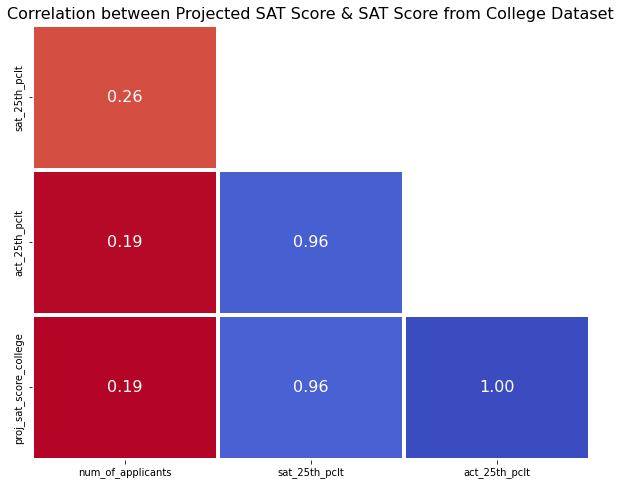

In [45]:
heatmap(sat_act_by_college)
plt.title("Correlation between Projected SAT Score & SAT Score from College Dataset", size='16');

### <span style="color: Blue;">Finding</span>

There is a strong positive correlation of 0.96 for the projected SAT score and the SAT score at 25th percentile of the college dataset. As the value is the same as the correlation value between the ACT score at 25th percentile and the SAT score at 25th percentile, this suggests that the SAT and ACT concordance table is generally a reliable indicator to measure the SAT score required from ACT score. However, further analysis is required to examine if this is the case for each individual college.

### 5.2 Correlation with State Dataset

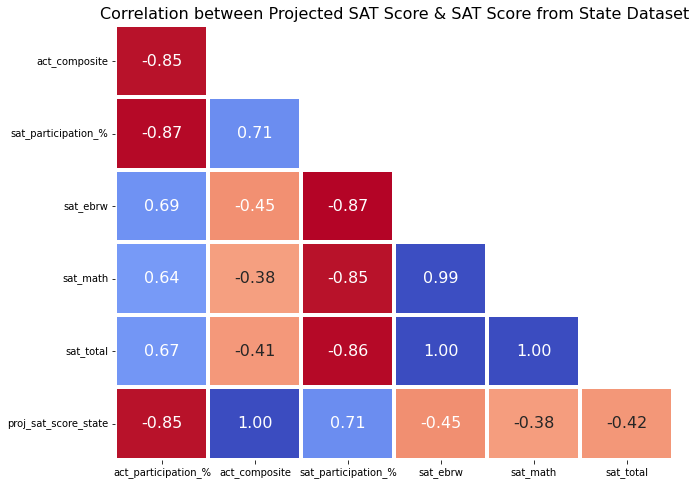

In [46]:
heatmap(act_sat_2019)
plt.title("Correlation between Projected SAT Score & SAT Score from State Dataset", size='16');

### <span style="color: Blue;">Finding</span>

There is a negative correlation of -0.42 for the projected SAT score and the SAT score of the state dataset. Nevertheless, this is close to the -0.41 correlation value between the ACT and SAT score. This suggests that the SAT and ACT concordance table is still a reliable indicator to measure the SAT score required from ACT score as a whole. However, like the college dataset, it remains to be seen if this is the case for each individual state.

There are also other findings worth highlighting from the above visualisation:
1. There is a strong negative correlation (-0.85) between ACT participation rate and ACT score. The same relationship holds true (-0.86) for SAT participation rate and SAT score. One possible explanation why the minority of each state did better in the less popular test than majority is that because they are more driven to do well in opting for the less popular test.
2. The negative correlation of -0.41 between the ACT and SAT score implies that states generally do better for either test.

## 6. Examining College Dataset

We shall examine the relationship between the projected SAT score and the 25th percentile SAT score of each college. 

In [47]:
# create a new column in the dataset to capture the difference in value 
sat_act_by_college['diff_between_sat_scores'] = sat_act_by_college['proj_sat_score_college']-sat_act_by_college['sat_25th_pclt']
sat_act_by_college.head()

,college,test_required?,class_year(s),policy_details,num_of_applicants,accept_rate,sat_25th_pclt,act_25th_pclt,proj_sat_score_college,diff_between_sat_scores
0,Stanford University,Yes,2021,Stanford has adopted a one-year test optional ...,47452,4.3%,1440,32,1430,-10
1,Harvard College,Yes,2021,Harvard has adopted a one-year test optional p...,42749,4.7%,1460,33,1460,0
2,Princeton University,Yes,2021,Princeton has adopted a one-year test optional...,35370,5.5%,1440,32,1430,-10
3,Columbia University,Yes,2021,Columbia has adopted a one-year test optional ...,40203,5.5%,1450,33,1460,10
4,Yale University,Yes,2021,Yale has adopted a one-year test optional poli...,36844,6.1%,1460,33,1460,0


In [48]:
# we want to help students to decide between which of the tests is more favourable to enter each college
# we will need a marker to differentiate between three categories: (1)ACT Preferred, (2)SAT Preferred and (3)Neutral
# we will set the marker as one standard deviation from mean to separate the categories
sat_act_by_college['diff_between_sat_scores'].std().round()

38.0

In [49]:
# create a new column to recommend students which test is more favourable
recommendation = []
for i in sat_act_by_college['diff_between_sat_scores']:
        if i > 38: recommendation.append('ACT Preferred')
        elif i < -38: recommendation.append('SAT Preferred')
        else: recommendation.append('Neutral')
sat_act_by_college['recommendation'] = recommendation
sat_act_by_college.head()

,college,test_required?,class_year(s),policy_details,num_of_applicants,accept_rate,sat_25th_pclt,act_25th_pclt,proj_sat_score_college,diff_between_sat_scores,recommendation
0,Stanford University,Yes,2021,Stanford has adopted a one-year test optional ...,47452,4.3%,1440,32,1430,-10,Neutral
1,Harvard College,Yes,2021,Harvard has adopted a one-year test optional p...,42749,4.7%,1460,33,1460,0,Neutral
2,Princeton University,Yes,2021,Princeton has adopted a one-year test optional...,35370,5.5%,1440,32,1430,-10,Neutral
3,Columbia University,Yes,2021,Columbia has adopted a one-year test optional ...,40203,5.5%,1450,33,1460,10,Neutral
4,Yale University,Yes,2021,Yale has adopted a one-year test optional poli...,36844,6.1%,1460,33,1460,0,Neutral


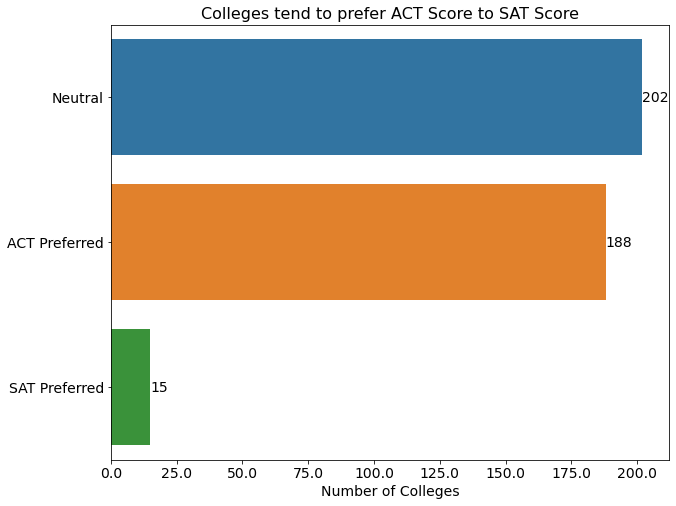

In [50]:
bar(sat_act_by_college)
plt.title("Colleges tend to prefer ACT Score to SAT Score", size='16')
plt.xlabel('Number of Colleges', size='14');

In [51]:
sat_act_by_college[sat_act_by_college['recommendation']=='SAT Preferred']['college']

35              Washington University in St. Louis
69         University of California—​Santa Barbara
101       California State University--Los Angeles
146               University of Wisconsin—​Madison
173            California State University--Fresno
223       University of North Carolina—​Wilmington
246    California State University--San Bernardino
269                University of California—Merced
347        California State University--Sacramento
351                 University of Alaska Anchorage
360                          University of Arizona
377                      Humboldt State University
380                             Washington College
387                                 Portland State
402                          Florida International
Name: college, dtype: object

### <span style="color: Blue;">Finding</span>

While most colleges have no preference over either test, the number of colleges which prefer ACT score is substantially more those which prefer SAT score. Hence, unless one's dream college belongs to the list of college preferring SAT, it would be more advisable for students to take ACT test in general. The finding is contrary to popular opinion that colleges do not prefer one test over another. See [crimson education](https://www.crimsoneducation.org/sg/blog/test-prep/sat-vs-act-whats-the-difference/), [the olive book](https://theolivebook.com/do-colleges-prefer-the-sat-or-the-act/) etc.

## 7. Examining State Dataset

We shall examine the relationship between the projected SAT score and the SAT score of each state.

In [52]:
act_sat_2019['diff_between_sat_scores'] = act_sat_2019['proj_sat_score_state']-act_sat_2019['sat_total']
act_sat_2019.head()

,state,act_participation_%,act_composite,sat_participation_%,sat_ebrw,sat_math,sat_total,proj_sat_score_state,diff_between_sat_scores
0,Alabama,100,19,7,583,560,1143,1010,-133
1,Alaska,38,20,41,556,541,1097,1040,-57
2,Arizona,73,19,31,569,565,1134,1010,-124
3,Arkansas,100,19,6,582,559,1141,1010,-131
4,California,23,23,63,534,531,1065,1140,75


In [53]:
act_sat_2019['diff_between_sat_scores'].std().round()

145.0

In [54]:
recommendation = []
for i in act_sat_2019['diff_between_sat_scores']:
        if i > 145: recommendation.append('ACT Preferred')
        elif i < -145: recommendation.append('SAT Preferred')
        else: recommendation.append('Neutral')
act_sat_2019['recommendation'] = recommendation
act_sat_2019.head()

,state,act_participation_%,act_composite,sat_participation_%,sat_ebrw,sat_math,sat_total,proj_sat_score_state,diff_between_sat_scores,recommendation
0,Alabama,100,19,7,583,560,1143,1010,-133,Neutral
1,Alaska,38,20,41,556,541,1097,1040,-57,Neutral
2,Arizona,73,19,31,569,565,1134,1010,-124,Neutral
3,Arkansas,100,19,6,582,559,1141,1010,-131,Neutral
4,California,23,23,63,534,531,1065,1140,75,Neutral


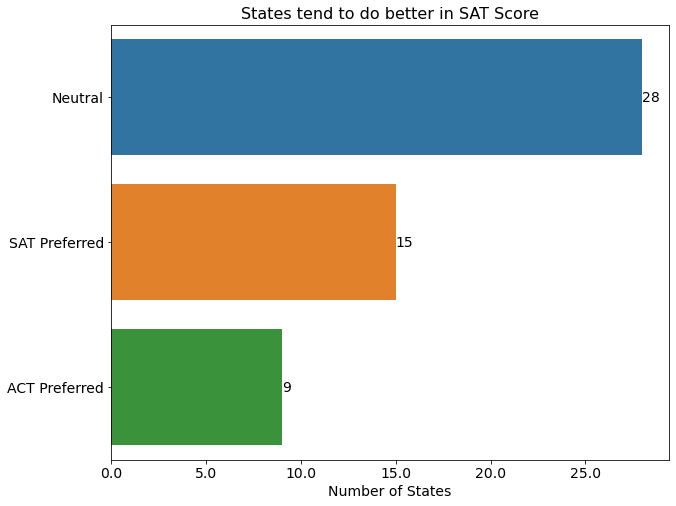

In [55]:
bar(act_sat_2019)
plt.title("States tend to do better in SAT Score", size='16')
plt.xlabel('Number of States', size='14');

### <span style="color: Blue;">Finding</span>

For more than half of the states, it is not clear that they do better for either test. Nevertheless, there are more states that do better in SAT test than ACT test. Given this information, there is incentive for high school students to choose their test based on the states they reside in.

## 8. Extra Analysis - Logistic Regression on the College Dataset

To further examine the factors contributing to a college's preference for either test, we shall conduct logistic regression on the college dataset. The college dataset was chosen over the state dataset as it has more fields in the dataset for analysis.

### 8.1 Preparation of College Dataset

In [56]:
# here's a recap on the current state for the college dataset
sat_act_by_college.head()

,college,test_required?,class_year(s),policy_details,num_of_applicants,accept_rate,sat_25th_pclt,act_25th_pclt,proj_sat_score_college,diff_between_sat_scores,recommendation
0,Stanford University,Yes,2021,Stanford has adopted a one-year test optional ...,47452,4.3%,1440,32,1430,-10,Neutral
1,Harvard College,Yes,2021,Harvard has adopted a one-year test optional p...,42749,4.7%,1460,33,1460,0,Neutral
2,Princeton University,Yes,2021,Princeton has adopted a one-year test optional...,35370,5.5%,1440,32,1430,-10,Neutral
3,Columbia University,Yes,2021,Columbia has adopted a one-year test optional ...,40203,5.5%,1450,33,1460,10,Neutral
4,Yale University,Yes,2021,Yale has adopted a one-year test optional poli...,36844,6.1%,1460,33,1460,0,Neutral


In [57]:
sat_act_by_college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 0 to 415
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   college                  405 non-null    object
 1   test_required?           405 non-null    object
 2   class_year(s)            380 non-null    object
 3   policy_details           405 non-null    object
 4   num_of_applicants        405 non-null    int64 
 5   accept_rate              405 non-null    object
 6   sat_25th_pclt            405 non-null    int64 
 7   act_25th_pclt            405 non-null    int64 
 8   proj_sat_score_college   405 non-null    int64 
 9   diff_between_sat_scores  405 non-null    int64 
 10  recommendation           405 non-null    object
dtypes: int64(5), object(6)
memory usage: 38.0+ KB


### <span style="color: Blue;">Observation</span>

There is a column with missing data. The 'class_year(s)' column contains the values of the years in which either SAT and ACT test is required for a college. Since the data is encapsulated under the 'test_required?' column, we shall proceed to drop it.

There are four further things that we want to adjust for the 'act_2019.csv' Dataset :-

1. Drop 'college' and 'policy_details' columns as we do not need to use them for analysis.
2. Drop 'diff_between_sat_scores' column as it is used to create the recommendation in the first place.
3. Drop columns that are not statistically significance.
4. Drop further columns with strong correlation with one another to avoid multicollinearity.

In [58]:
sat_act_by_college.pop('college')
sat_act_by_college.pop('class_year(s)')
sat_act_by_college.pop('policy_details')
sat_act_by_college.pop('diff_between_sat_scores')
print(sat_act_by_college.head())

  test_required?  num_of_applicants accept_rate  sat_25th_pclt  act_25th_pclt  \
0            Yes              47452        4.3%           1440             32   
1            Yes              42749        4.7%           1460             33   
2            Yes              35370        5.5%           1440             32   
3            Yes              40203        5.5%           1450             33   
4            Yes              36844        6.1%           1460             33   

   proj_sat_score_college recommendation  
0                    1430        Neutral  
1                    1460        Neutral  
2                    1430        Neutral  
3                    1460        Neutral  
4                    1460        Neutral  


In [59]:
sat_act_by_college['test_required?'].value_counts()
sat_act_by_college['test_required?'] = sat_act_by_college['test_required?'].map({'Yes': 1, 'No': 0, 'Yes (TB)': 1, 'Yes*': 1, 'Yes (TF)': 1})

In [60]:
sat_act_by_college['test_required?'].value_counts()

1    380
0     25
Name: test_required?, dtype: int64

In [61]:
sat_act_by_college['accept_rate'] = sat_act_by_college['accept_rate'].str.replace('%','').astype(float)
print(sat_act_by_college.head())

   test_required?  num_of_applicants  accept_rate  sat_25th_pclt  \
0               1              47452          4.3           1440   
1               1              42749          4.7           1460   
2               1              35370          5.5           1440   
3               1              40203          5.5           1450   
4               1              36844          6.1           1460   

   act_25th_pclt  proj_sat_score_college recommendation  
0             32                    1430        Neutral  
1             33                    1460        Neutral  
2             32                    1430        Neutral  
3             33                    1460        Neutral  
4             33                    1460        Neutral  


In [62]:
sat_act_by_college_cols = [col for col in sat_act_by_college.columns if col not in ['recommendation']]
print(len(sat_act_by_college_cols))
sat_act_by_college_cols

6


['test_required?',
 'num_of_applicants',
 'accept_rate',
 'sat_25th_pclt',
 'act_25th_pclt',
 'proj_sat_score_college']

In [63]:
results_dict = {col:cont_stat_sig_test(sat_act_by_college,col) for col in sat_act_by_college_cols}

test_required?: non-normal distribution, KW test, not statistically significant, 0.9805104545996376
num_of_applicants: non-normal distribution, KW test, statistically significant, 0.0016802221969996521
accept_rate: non-normal distribution, KW test, not statistically significant, 0.11343708425702986
sat_25th_pclt: non-normal distribution, KW test, statistically significant, 0.04277950173985062
act_25th_pclt: non-normal distribution, KW test, statistically significant, 4.577685383924265e-08
proj_sat_score_college: normal distribution, Anova test, statistically significant, 6.346813959126099e-09


In [64]:
# drop the columns that are not statistically significant
sat_act_by_college.pop('test_required?')
sat_act_by_college.pop('accept_rate')
print(sat_act_by_college.head())

   num_of_applicants  sat_25th_pclt  act_25th_pclt  proj_sat_score_college  \
0              47452           1440             32                    1430   
1              42749           1460             33                    1460   
2              35370           1440             32                    1430   
3              40203           1450             33                    1460   
4              36844           1460             33                    1460   

  recommendation  
0        Neutral  
1        Neutral  
2        Neutral  
3        Neutral  
4        Neutral  


In [65]:
sat_act_by_college['recommendation'] = sat_act_by_college['recommendation'].map({'Neutral': 0, 'ACT Preferred': 1, 'SAT Preferred': 2})

In [66]:
sat_act_by_college['recommendation'].value_counts()

0    202
1    188
2     15
Name: recommendation, dtype: int64

In [67]:
print(sat_act_by_college.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 0 to 415
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   num_of_applicants       405 non-null    int64
 1   sat_25th_pclt           405 non-null    int64
 2   act_25th_pclt           405 non-null    int64
 3   proj_sat_score_college  405 non-null    int64
 4   recommendation          405 non-null    int64
dtypes: int64(5)
memory usage: 19.0 KB
None


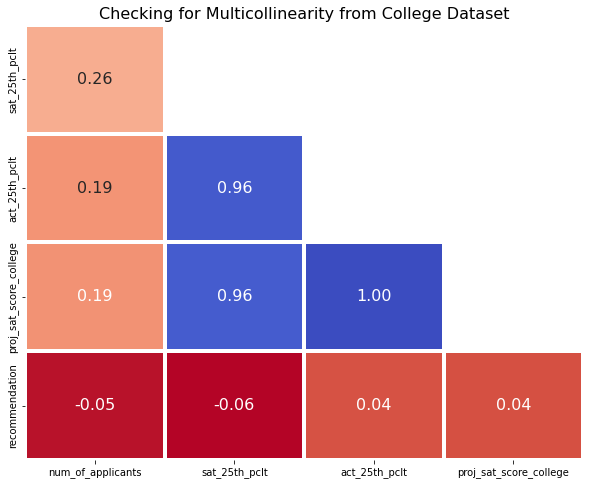

In [68]:
heatmap(sat_act_by_college)
plt.title("Checking for Multicollinearity from College Dataset", size='16');

In [69]:
# There are three columns with strong correlation with each other
# I shall drop the 'proj_sat_score_college' and 'act_25th_pclt' columns as the values from 'act_25th_pclt' was used to project the values of 'proj_sat_score_college'
sat_act_by_college.pop('act_25th_pclt')
sat_act_by_college.pop('proj_sat_score_college')
print(sat_act_by_college.head())

   num_of_applicants  sat_25th_pclt  recommendation
0              47452           1440               0
1              42749           1460               0
2              35370           1440               0
3              40203           1450               0
4              36844           1460               0


In [70]:
# used seed = 42 to ensure consistency of value
X = sat_act_by_college.drop(columns = 'recommendation')
y = sat_act_by_college['recommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [71]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [72]:
logreg.score(X_train, y_train)

0.5610561056105611

In [73]:
cross_val_score(logreg, X_train, y_train).mean()

0.5446994535519126

In [74]:
logreg.score(X_test, y_test)

0.5882352941176471

### <span style="color: Blue;">Finding</span>

With a logistic regression score of 0.56, the features 'num_of_applicants' and 'sat_25th_pclt' are not able to predict the recommendation for high school students on the test to take. The test result of 0.59 reinforces the result. Hence, there is a need to look beyond the variables from the college dataset in order to improve the accuracy of the regression.

## 9. Extra Analysis - Logistic Regression on the State Dataset

In [75]:
# Here's a recap on the current state for the state dataset
act_sat_2019.head()

,state,act_participation_%,act_composite,sat_participation_%,sat_ebrw,sat_math,sat_total,proj_sat_score_state,diff_between_sat_scores,recommendation
0,Alabama,100,19,7,583,560,1143,1010,-133,Neutral
1,Alaska,38,20,41,556,541,1097,1040,-57,Neutral
2,Arizona,73,19,31,569,565,1134,1010,-124,Neutral
3,Arkansas,100,19,6,582,559,1141,1010,-131,Neutral
4,California,23,23,63,534,531,1065,1140,75,Neutral


In [76]:
act_sat_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   state                    52 non-null     object
 1   act_participation_%      52 non-null     int64 
 2   act_composite            52 non-null     int64 
 3   sat_participation_%      52 non-null     int64 
 4   sat_ebrw                 52 non-null     int64 
 5   sat_math                 52 non-null     int64 
 6   sat_total                52 non-null     int64 
 7   proj_sat_score_state     52 non-null     int64 
 8   diff_between_sat_scores  52 non-null     int64 
 9   recommendation           52 non-null     object
dtypes: int64(8), object(2)
memory usage: 4.5+ KB


### <span style="color: Blue;">Observation</span>

There is no missing data in the dataset.

To prepare for logistic regression analysis, we will proceed with the following :-

1. Drop 'state' column as we do not need to use it.
2. Drop 'diff_between_sat_scores' column as it is used to create the recommendation in the first place.
3. Drop columns that are not statistically significance.
4. Drop further columns with strong correlation with one another to avoid multicollinearity.

In [77]:
act_sat_2019.pop('state')
act_sat_2019.head()

,act_participation_%,act_composite,sat_participation_%,sat_ebrw,sat_math,sat_total,proj_sat_score_state,diff_between_sat_scores,recommendation
0,100,19,7,583,560,1143,1010,-133,Neutral
1,38,20,41,556,541,1097,1040,-57,Neutral
2,73,19,31,569,565,1134,1010,-124,Neutral
3,100,19,6,582,559,1141,1010,-131,Neutral
4,23,23,63,534,531,1065,1140,75,Neutral


In [78]:
act_sat_2019_cols = [col for col in act_sat_2019.columns if col not in ['recommendation']]
print(len(act_sat_2019_cols))
act_sat_2019_cols

8


['act_participation_%',
 'act_composite',
 'sat_participation_%',
 'sat_ebrw',
 'sat_math',
 'sat_total',
 'proj_sat_score_state',
 'diff_between_sat_scores']

In [79]:
esults_dict = {col:cont_stat_sig_test(act_sat_2019,col) for col in act_sat_2019_cols}
sat_act_by_college_results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['p_value']).sort_values(by='p_value')

act_participation_%: non-normal distribution, KW test, statistically significant, 9.366002554858438e-07
act_composite: normal distribution, Anova test, statistically significant, 2.3295240491917547e-07
sat_participation_%: non-normal distribution, KW test, statistically significant, 1.441063663279962e-08
sat_ebrw: non-normal distribution, KW test, statistically significant, 2.3677976267640396e-08
sat_math: normal distribution, Anova test, statistically significant, 1.877893233338882e-14
sat_total: normal distribution, Anova test, statistically significant, 3.2782489283878107e-15
proj_sat_score_state: non-normal distribution, KW test, statistically significant, 3.817635173503496e-05
diff_between_sat_scores: non-normal distribution, KW test, statistically significant, 9.393411690189057e-10


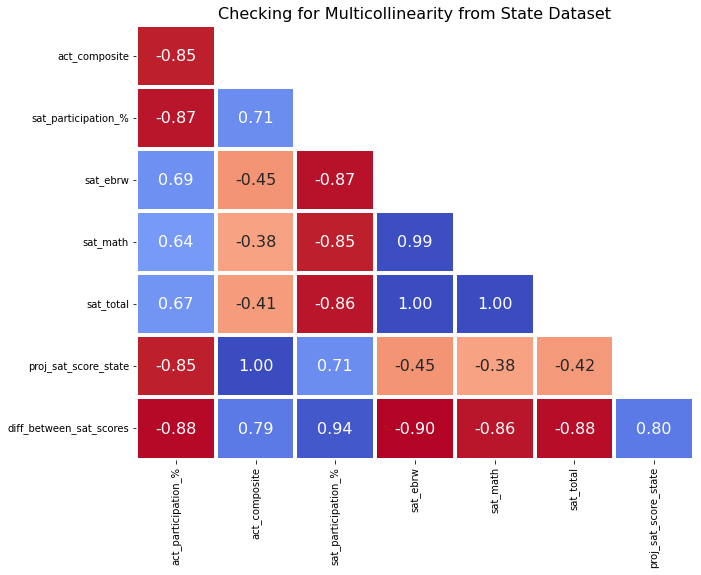

In [80]:
# there is no need to drop any column as they are all statistically significant
heatmap(act_sat_2019)
plt.title("Checking for Multicollinearity from State Dataset", size='16');

In [81]:
# dropping all the columns with strong correlation except 'act_participation_%' column
act_sat_2019.pop('sat_ebrw')
act_sat_2019.pop('sat_math')
act_sat_2019.pop('act_composite')
act_sat_2019.pop('sat_participation_%')
act_sat_2019.pop('sat_total')
act_sat_2019.pop('proj_sat_score_state')
act_sat_2019.pop('diff_between_sat_scores')
act_sat_2019.head()

,act_participation_%,recommendation
0,100,Neutral
1,38,Neutral
2,73,Neutral
3,100,Neutral
4,23,Neutral


In [82]:
act_sat_2019['recommendation'] = act_sat_2019['recommendation'].map({'Neutral': 0, 'ACT Preferred': 1, 'SAT Preferred': 2})

In [83]:
X = act_sat_2019.drop(columns = 'recommendation')
y = act_sat_2019['recommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [84]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [85]:
logreg.score(X_train, y_train)

0.7692307692307693

In [86]:
cross_val_score(logreg, X_train, y_train).mean()

0.7714285714285715

In [87]:
logreg.score(X_test, y_test)

0.6153846153846154

### <span style="color: Blue;">Finding</span>

The logistic regression from the state dataset has reasonably good predictive power of 0.77 based on the sole feature of 'act_participation_%'. However, there is a discrepancy with the test result of 0.62. Nevertheless, even with the lower test result, it is fair to conclude that ACT participatin rate is a useful predictor of test recommendation for state. Further analysis can be done to further improve the score by including other possible features in the regression.

## 10. Summary

The following are the key findings of this project:

1. The SAT and ACT concordance table taken from the respective official SAT and ACT website is useful as a convertor for SAT and ACT scores in general.
2. However, as we propped deeper into individual colleges and states, there is a preference for either tests even though the most colleges and states are neutral. 
3. There is an obvious preference for ACT score for colleges. Apart from the only 15 colleges that prefers SAT scores, high school students are advised to take ACT to increase their likelihood of getting into college.
4. Slightly more states do better in SAT test than ACT test. High school students are also suggested to base their decision to take either test based on their geographical location.
5. Logistic regression analysis from the college dataset does not return any promising result.
6. Logistic regression analysis from the state dataset reveals that the participation rate of ACT is a fairly good predictor on the best performing test for each state.

In closure, it is worth highlighting the limitations of this project. The analysis was conducted using the past data from 2019. For the latest trend, data will need to be up-to-date. More importantly, the recommendations provided for high school students are based on general trends derived from colleges and states data. There might be other relevant data not captured in this project that can further provide insights for high school students. For each high school student to decide between taking ACT or SAT test, other factors, such as individual preference and strengths, should also be taken into consideration. Nevertheless, the project hopes that the findings can provide useful insights for high school students to aid their decision making.